In [88]:
# Import
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [89]:
# Parameters
n = 30
C = 10
meanT = 9.3
meanM = 30
oneItemST = 3

# Factors

# FME_Exponential
p = [0.1,0.2,0.3,0.4,0.5]
K = [9,10,11,12,13,14,15,16,17,18,19,20,21]


# CSV name
csv_name = "FME_Exponential_a_New"

In [90]:

CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)

CSV = pd.concat([CSV[CSV["type"] == "vector"], CSV[CSV["attrname"] == "iterationvarsd"]])

# CSV.to_csv(f"{csv_name}_cleaned.csv", index=False)

C:\Users\giova\AppData\Local\Temp\ipykernel_15660\2527533774.py:1: DtypeWarning: Columns (2,3,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  CSV = pd.read_csv(f"{csv_name}.csv").fillna(0)


In [91]:

# In the rows where attrname == "iterationvarsd", 
# attrvalue contains the current configuration
# in the following format: exponential(30s,_0)
configurationInfo = CSV[CSV["attrname"] == "iterationvarsd"]

CSV_Vector = CSV[CSV["type"] == "vector"]

# TW: Total Mean Waiting Time [GlobalSink]
Exp_TW = CSV_Vector[CSV_Vector["module"].str.contains("SuperMarket.globalSink")]
Exp_TW = Exp_TW[Exp_TW["name"] == "totalQueueingTime:vector"]


# Dictionary for containing all the DataFrames
CSV_Dict = {
    "TW": Exp_TW
}

# PI: Performance Indexes
PI = {}

# Configurations
config = {}

for _, row in configurationInfo.iterrows():
    # The key of config is the run number and the value is the value of T
    config[row["run"].split("-")[2]] = row["attrvalue"].replace("/", "_")


for key in CSV_Dict:
    
    # --- Initialization Phase ---
    # The key of PI is the Performance Index and the value is a dictionary
    PI[key] = {}

    for c in config:
        # config[c] is a value of T
        PI[key][config[c]] = {}

        for cc in config:
            # cc contains the run number
            PI[key][config[c]][cc] = {}
    # --- End of Initialization Phase ---

    for _, row in CSV_Dict[key].iterrows():
        # each row of CSV_Dict[key] is a run of the simulation with a specific value of T

        # In row we save the run number
        run = row["run"].split("-")[2]

        # Using a regex we search for all the occurencies of numbers inside row['module']
        q = re.findall(r'\d+', row["module"])

        if q:
            # If a number was found
            # e.g. SuperMarket.checkout.queues[0]
            # We take the first one (and only one)
            q = q[0]

            string = f"Q{q}"
            if key == "W":
                PI[key][config[run]][run][string] = row["vecvalue"]

            else:
                # For the current run we save the PI value of the queue "string" (e.g. Q0)
                PI[key][config[run]][run][string] = float(row["value"]) 

        else:
            # If none number was found
            # e.g. SuperMarket.globalSink

            if key == "TW":
                PI[key][config[run]][run] = row["vecvalue"]
            else:
                # For the current run we save the PI value of the overall system
                PI[key][config[run]][run] = float(row["value"])


# PI_df: Performance Indexes DataFrame
PI_df = {}

# In Q we are going to save the names of the queues in the format Q0, Q1, ...
Q = []
for i in range(C):
    Q.append(f"Q{i}")


# --- Initialization Phase ---

for pi in PI:

    # The key of PI_df is the Performance Index and the value is a dictionary
    PI_df[pi] = {}

    for config in PI[pi]:

        if pi != "TW":
            # If pi is not TW we create a DataFrame with the columns Q (one column for each queue)
            PI_df[pi][config] = pd.DataFrame(columns=Q)

        else:
            # If pi is TW we create a DataFrame with just one column GS (Global Sink)
            PI_df[pi][config] = pd.DataFrame(columns=["GS"])

# --- End of Initialization Phase ---


for pi in PI:

    for config in PI[pi]:
    
        for run in PI[pi][config]:
            
            # Here we need to check if PI[pi][config][run] is different from {}
            # because if it is {} it means that the run was not related to 
            # that specific value of T
            if PI[pi][config][run]:

                # Check if PI[pi][config][run] is a dictionary
                if isinstance(PI[pi][config][run], dict):
                    # If it is a dictionary it means that
                    # it contains the PI values for each queue
                    for q in PI[pi][config][run]:
                        # We add the PI value of the queue q to the DataFrame
                        # at the row 'run' and at the column 'q'
                        PI_df[pi][config].loc[int(run), q] = PI[pi][config][run][q]
                else:
                    # If it is not a dictionary it means that
                    # it contains the PI value for the overall system

                    # We add the PI value of the overall system to the DataFrame
                    # at the row 'run'
                    PI_df[pi][config].loc[int(run)] = PI[pi][config][run]

        # We sort the DataFrame by the index (run number)
        PI_df[pi][config] = PI_df[pi][config].sort_index()
        # We reset the index of the DataFrame to start from 0
        PI_df[pi][config] = PI_df[pi][config].reset_index(drop=True)



In [92]:
# from statsmodels.graphics.gofplots import qqplot
# from pandas.plotting import lag_plot

# values = PI_df["TW"]["0.1_14"]["GS"].iloc[0]
# values = values.split(" ")
# values = [float(i) for i in values]
# values = pd.DataFrame(values)
# lag_plot(values)
# plt.show()
# subsample = values.sample(frac=0.3)
# subsample.sort_index(inplace=True)
# lag_plot(subsample)
# plt.show()
# sns.distplot(values, hist=False, rug=True)
# plt.show()

In [93]:
# Subsampling and Mean Computation
for p_ in p:
    for K_ in K:
        for index, row in PI_df["TW"][f"{p_}_{K_}"].iterrows():
            values = row["GS"].split(" ")
            values = [float(v) for v in values]
            values = pd.DataFrame(values)
            subsample = values.sample(frac=0.3)
            PI_df["TW"][f"{p_}_{K_}"].loc[index, "GS"] = subsample.mean()[0]

In [94]:
PI_df["TW"]["0.1_14"]

,GS
0,182.937145
1,260.631188
2,136.30172
3,301.524489
4,404.946627
5,254.756879
6,281.047039
7,176.091322
8,393.402274
9,263.11463


In [95]:
pi = "TW"
P_LOG = {}
P_LOG[pi] = {}

for p_ in p:
    for K_ in K:
        P_LOG[pi][f"{p_}_{K_}"] = pd.DataFrame(columns=["GS"])
        P_LOG[pi][f"{p_}_{K_}"]["GS"] = np.log(PI_df[pi][f"{p_}_{K_}"]["GS"].values.astype(np.float64).tolist())


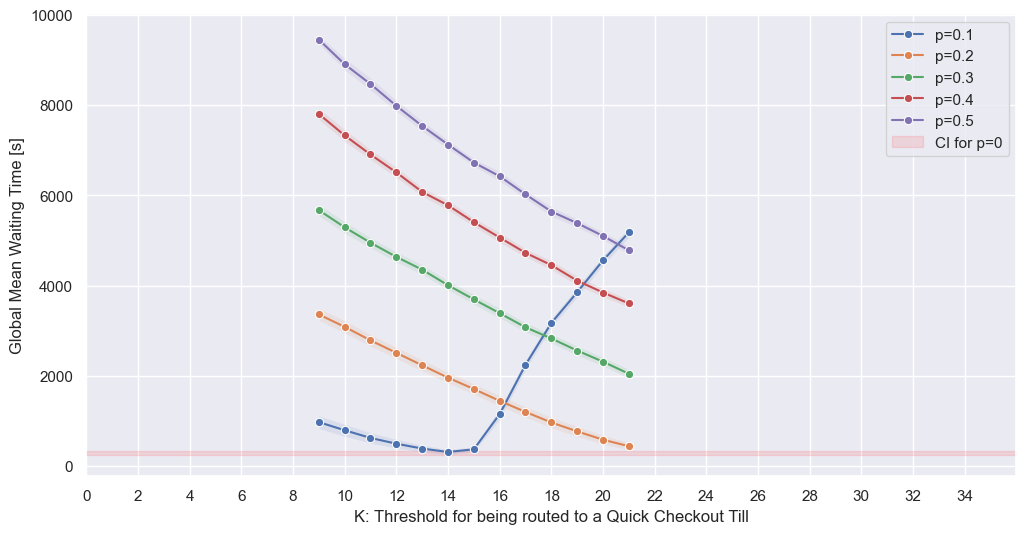

In [96]:
# (Normal)
# Total Waiting Time (Global Sink)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"


for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["GS"].mean())

        # We compute the confidence interval bounds
        ci_lb.append(PI_df[pi][couple]["GS"].mean() - (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))
        ci_ub.append(PI_df[pi][couple]["GS"].mean() + (1.96 * (PI_df[pi][couple]["GS"].std() / math.sqrt(n))))

    # We plot the confidence intervals
    plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}")


# Mean Value in the case of p = 0 285.016
# Confidence Interval Bounds: LB: 243.477  UB: 330.132
# plt.fill_between(y=[243.477, 330.132], alpha=0.1)
# plt.axhline(y=243.477, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=330.132, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([243.477, 330.132], 0, 36, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 36, 2))

# Set the x-axis limits
plt.xlim(0, 36)  
# Set the y-axis limits
# plt.ylim(250, 450)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of the overall system')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Global Mean Waiting Time [s]')

plt.legend()
plt.show()

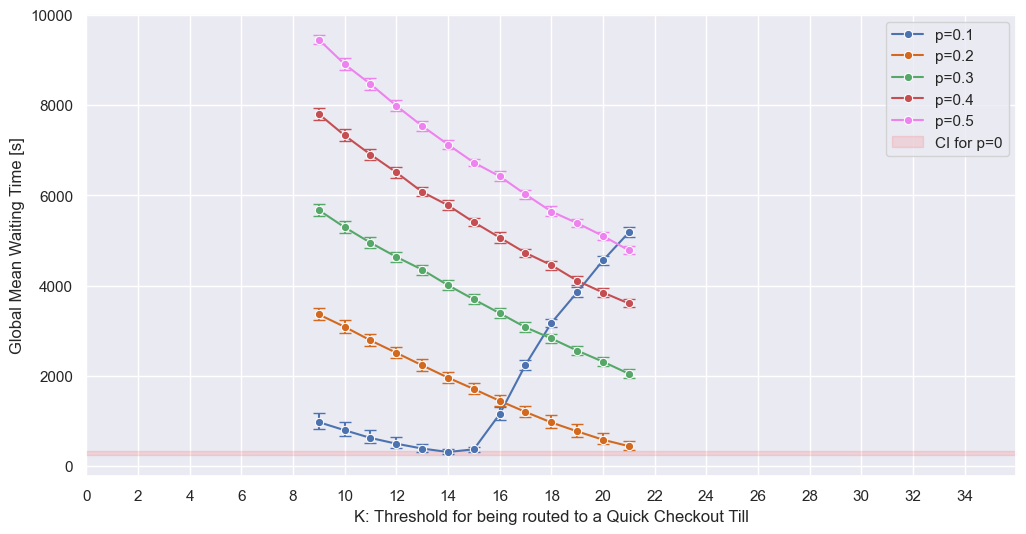

In [97]:
# (Cox Method)
# Total Waiting Time (Global Sink)

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Performance Index
pi = "TW"

temp_colors = ["b", "chocolate", "g", "r", "violet"]
colors = {}
for p_ in p:
    colors[p_] = temp_colors.pop(0)

for p_ in p:

    # We save in y_W all the values for the current p_
    y_W = []
    
    # Confidence Interval Bounds
    ci_AA = []
    ci_BB = []

    ci_lb = []
    ci_ub = []
    

    for k in K:
        
        # Current configuration
        couple = f"{p_}_{k}"
        
        # We add one value to y_W
        y_W.append(PI_df[pi][couple]["GS"].mean())

        # We compute the confidence interval bounds
        
        # mean + s^2/2 +_ 1.96 * sqrt(s^2/n + s^4/2(n-1))
        ci_AA.append(PI_df[pi][couple]["GS"].mean() - np.exp(P_LOG[pi][couple]["GS"].mean() + (P_LOG[pi][couple]["GS"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][couple]["GS"].std()**2 / n) + (P_LOG[pi][couple]["GS"].std()**4 / (2 * (n-1)))))))
        ci_BB.append(np.exp(P_LOG[pi][couple]["GS"].mean() + (P_LOG[pi][couple]["GS"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][couple]["GS"].std()**2 / n) + (P_LOG[pi][couple]["GS"].std()**4 / (2 * (n-1)))))) - PI_df[pi][couple]["GS"].mean())

        ci_lb.append(np.exp(P_LOG[pi][couple]["GS"].mean() + (P_LOG[pi][couple]["GS"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[pi][couple]["GS"].std()**2 / n) + (P_LOG[pi][couple]["GS"].std()**4 / (2 * (n-1)))))))
        ci_ub.append(np.exp(P_LOG[pi][couple]["GS"].mean() + (P_LOG[pi][couple]["GS"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[pi][couple]["GS"].std()**2 / n) + (P_LOG[pi][couple]["GS"].std()**4 / (2 * (n-1)))))))


    # We plot the confidence intervals
    # plt.fill_between(K, ci_lb, ci_ub, alpha=0.1)

    # We plot the error bars
    plt.errorbar(x=K, y=y_W, fmt='o', yerr=[ci_AA, ci_BB], markersize=3, capsize=4, color=colors[p_])

    # We plot the line for the current p_
    sns.lineplot(x=K, y=y_W, marker='o', label=f"p={p_}", color=colors[p_])


# Mean Value in the case of p = 0 285.016
# Confidence Interval Bounds: LB: 243.477  UB: 330.132
# plt.fill_between(y=[243.477, 330.132], alpha=0.1)
# plt.axhline(y=243.477, color='red', alpha=0.3, linestyle='-')
# plt.axhline(y=330.132, color='red', alpha=0.3, linestyle='-')
plt.fill_betweenx([243.477, 330.132], 0, 36, color='red', alpha=0.1, label="CI for p=0")

plt.xticks(np.arange(0, 36, 2))

# Set the x-axis limits
plt.xlim(0, 36)  
# Set the y-axis limits
# plt.ylim(250, 450)  

# plt.title('Line Plot with Confidence Intervals for the Waiting Time of the overall system')
plt.xlabel('K: Threshold for being routed to a Quick Checkout Till')
plt.ylabel('Global Mean Waiting Time [s]')

plt.legend()
plt.show()